# Overview
The previous attempt at topic modeling via LDA ultimately used the cosine similarity between documents and the topic vectors and then assigned each document to the topic that resulted in the highest similarity. The .csv file that displayed the documents and their assigned topic ID showed the documents in decreasing order of the simiarity between the document and the topic. However, when showing these documents, the highest scored documents may not be related and this can damage the credibility of the topic modeling from the user's perspective. To improve the presentation of the top documents in the cluster, once the documents have been assigned to their cluster, the centroid document will be found and then the top `N` documents will be the ones closest to the centroid. This will refine the topics in a way that hones in on a particular subset of documents within the topic that are particularly similar.

### Advantages
* Improved perceived coherence between topic documents
    * Top `n-grams` can be retrieved from just these top documents so they are also relevant to what is displayed
* Relatively easy to implement given the current approach

### Disadvantages
* This essentially finds the tightest subcluster within a topic and without further modification, the other subclusters will be ignored
* The top key terms for a topic may include terms from the neglected subclusters, potentially causing some confusion
    * Perhaps the key terms can be modified to just include those that are present in the top documents?
    
    
## Approach
The approach will be the same as the previous experiment in `Topic Modeling with LDA`, but a new function will be added that finds the centroid document within a list of documents and returns the top `N` documents closest to the centroid (including the centroid). Furthermore, the top n-grams and "Best Sentence" will be computed from that new set of top documents. The code from the previous notebook will be restructed into a `LDATopicModeler` class to closer resemble the other notebook that uses K-means. 

### Potential improvements
* Instead of a hard cutoff of `N` documents, add all documents within some threshold distance. This will allow all of the documents that are close to the centroid to be added and topics can have varying sizes. 
    

In [1]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
    
import scripts.corpora as corpora
from topic_modeling.lda_helpers import get_top_words, get_doc_counts_per_topic,\
                                       get_top_topics, get_top_n_grams
from topic_modeling.lda_helpers import get_topic_centroid_idx, get_closest_docs_indices, keep_top_n_features
from topic_modeling.naming import find_best_sentence

import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('fivethirtyeight')
%pylab inline
pylab.rcParams['figure.figsize'] = (25, 6)

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation
import numpy as np
from collections import defaultdict

from time import time

import numpy as np


[nltk_data] Downloading package punkt to /home/michael/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
Populating the interactive namespace from numpy and matplotlib


In [2]:
MIN_DF = 1
MAX_DF = 0.1
N_JOBS = -1   # use all available CPUs

class LDATopicModeler:

    # epsilon is the minimum similarity for including a document
    def __init__(self, corpus, n_topics, epsilon=0, max_features=None, key=None):
        if not key:
            key = lambda x: x
        self.corpus = corpus
        self.n_topics = n_topics
        self.epsilon = epsilon
        self.key = key
        self.max_features = max_features
        self.bodies = [self.key(document) for document in self.corpus]
        self.topic_bodies = None
        self.model, self.vectorizer = None, None
        self.topic_df = None
        self.document_df = None

    #DONE
    def run(self):
        print("Starting training for {} topics.".format(self.n_topics))
        
        start = time()
        vectors = self.vectorize(self.max_features)
        print("Vectors extracted in %0.3fs." % (time() - start))
        
        t0 = time()
        self.model = LatentDirichletAllocation(n_components=self.n_topics, 
                                               max_iter=5,
                                               learning_method='online',
                                               learning_offset=50.,
                                               random_state=0,
                                               n_jobs=N_JOBS,
                                              ).fit(vectors)
        # Normalize topic vectors
        self.model.components_ = self.model.components_ / self.model.components_.sum(axis=1)[:, np.newaxis]
        
        # keep top 25% of features
        num_features_to_keep = math.ceil(self.model.components_.shape[1]/4)
        self.model.components_ = keep_top_n_features(self.model.components_, num_features_to_keep)
        print("Model fit in  %0.3fs." % (time() - t0))
       
        t0 = time()
        self.topic_df = self.create_topic_df()
        print("Topic dataframe created in  %0.3fs." % (time() - t0))
        
        t0 = time()
        self.document_df = self.create_document_df()
        print("Document dataframe created in  %0.3fs." % (time() - t0))
        
        t0 = time()
        self.add_top_n_grams()
        print("Top n-grams computed in  %0.3fs." % (time() - t0))
        
        self.add_best_sentences()
        print("Process completed in  %0.3fs." % (time() - start))

    #DONE
    def vectorize(self, max_features):
        self.vectorizer = CountVectorizer(max_df=MAX_DF, min_df=MIN_DF,
                                          max_features=max_features,
                                          stop_words='english'
                                         )      
        vectors = self.vectorizer.fit_transform(self.bodies)
        return vectors
    
    
    def create_topic_df(self, num_top_words=5, verbose=False):
        tf_feature_names = self.vectorizer.get_feature_names()
        top_words = get_top_words(self.model, tf_feature_names, num_top_words)
        
        if verbose:
            for topic_idx, words in enumerate(top_words):
                print("Topic #{}: {}".format(topic_idx, words))
        
        sizes = get_doc_counts_per_topic(self.bodies, 
                                         self.model, 
                                         self.vectorizer, 
                                         hard_clustering=True)
        #plot_doc_counts(sizes)
        return pd.DataFrame({"Key terms": top_words,
                             "Size": [val for _, val in sorted(sizes.items())]})
    
    
    def create_document_df(self):

        ranked_bodies = []
        ranked_scores = []
        ranked_topic_ids = []
        
        self.topic_bodies = {}
        self.topic_centroids = {}
        for idx in range(self.n_topics):
            self.topic_bodies[idx] = []
            
        for body in self.bodies:
            topic, scores = get_top_topics(body, self.model, self.vectorizer, hard_clustering=True)
            self.topic_bodies[topic[0]].append(body)
            
        for topic_idx, bodies in self.topic_bodies.items():
            try:
                tdm = TfidfVectorizer(stop_words='english').fit_transform(bodies)
                centroid_idx = get_topic_centroid_idx(tdm)
                ranked_indices, scores = get_closest_docs_indices(tdm, centroid_idx)
                ranked_bodies.extend([bodies[i] for i in ranked_indices[0]])
                ranked_scores.extend([(-scores[0][i]) for i in ranked_indices[0]])
                ranked_topic_ids.extend([topic_idx]*len(bodies))
            except:
                pass

        document_df = pd.DataFrame(
                                {"Topic ID": ranked_topic_ids,
                                 "body": ranked_bodies,
                                 "Score": ranked_scores
                                })
        return document_df
    
    def add_top_n_grams(self):

        top_1_grams = []
        top_2_grams = []
        top_3_grams = []
        for topic_idx in range(self.n_topics):          
            bodies = self.document_df[\
                                      (self.document_df["Topic ID"]==topic_idx) & 
                                      (self.document_df["Score"]>self.epsilon)\
                                     ]["body"].tolist()
            top_1_grams.append(get_top_n_grams(bodies, 1, 5))
            top_2_grams.append(get_top_n_grams(bodies, 2, 5))
            top_3_grams.append(get_top_n_grams(bodies, 3, 5))

        self.topic_df["Top 1-grams"] = top_1_grams
        self.topic_df["Top 2-grams"] = top_2_grams
        self.topic_df["Top 3-grams"] = top_3_grams
        
    def add_best_sentences(self):
        #get best sentence

        best_sentences = {}
        for idx in range(self.n_topics):
            best_sentences[idx] = ""
        for topic_idx in range(self.n_topics):
            try: 
                top = self.document_df[(self.document_df["Topic ID"]==topic_idx) &
                                        (self.document_df["Score"]>=.99)]["body"].tolist()[0]
                best_sentences[topic_idx] = top
            
            except Exception as err:
                print("Failed for topic {}: {}".format(topic_idx, err))

        self.topic_df["Best sentence"] = best_sentences.values()

        
def export_documents(modeler, directory):
    modeler.document_df = modeler.document_df[["Topic ID", "Score", "body"]]
    modeler.document_df.to_csv(directory + "documents-LDA.csv", index=False)
    
def export_topics(modeler, directory):
    modeler.topic_df.index.name = 'Topic ID'
    modeler.topic_df.to_csv(directory+"topics-LDA.csv")

## Input Data

In [3]:
last_week = corpora.load('../corpora/vmware-last-week')
last_month = corpora.load('../corpora/vmware-last-month')
last_six_months = corpora.load('../corpora/vmware-last-six-months')
vsphere_65 = corpora.load('../corpora/vsphere-6.5-last-month')

In [4]:
def show_count_histogram(modeler, title, bins=100):
    labels = modeler.document_df["Topic ID"].tolist()
    plt.hist([labels.count(n) for n in range(modeler.n_topics)], bins=bins, color='grey')
    plt.title(title)
    plt.xlabel('Number of Searches')
    plt.show()

## Vsphere 6.5 Last Month 10 Topics

In [5]:
modeler = LDATopicModeler(vsphere_65, 10, key=lambda search: search.body)
modeler.run()

Starting training for 10 topics.
Vectors extracted in 0.097s.
Model fit in  7.488s.
Topic dataframe created in  8.589s.
Document dataframe created in  8.701s.
Top n-grams computed in  0.729s.
Process completed in  25.621s.


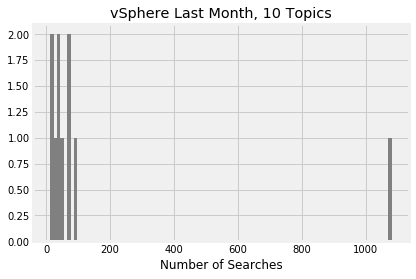

In [6]:
show_count_histogram(modeler, "vSphere Last Month, 10 Topics")

In [7]:
modeler.document_df[modeler.document_df["Score"]>0][["Topic ID", "body"]].groupby(["Topic ID"]).agg(['count'])

,body
,count
Topic ID,
0,19
1,32
2,8
3,57
4,805
5,49
6,59
7,38


In [8]:
len(modeler.document_df[modeler.document_df["Score"]>0])

1098

In [9]:
modeler.topic_df

,Key terms,Size,Top 1-grams,Top 2-grams,Top 3-grams,Best sentence
0,usr lib downloads tls packages,26,"[host, tls, error, scratch, esxi]","[syncronize host, esxi host, usr lib, scratch ...","[profile applying syslog, host profile applyin...",Getting alarm on ESXi server\n\nAlarm Definiti...
1,loading el backup v00 hostname,49,"[vcenter, hosts, server, backup, disconnected]","[vcenter server, hosts disconnecting, host dis...","[vmware remote console, vcenter server reslovi...",Vcenter randomly stops communicating with host...
2,duplicate key mem virtualcenter insert,13,"[esxi, loops, server, duplicate, vrops]","[esxi loops, duplicate datacenter, datacenter ...","[duplicate datacenter vrops, enable configure ...","Hi, after migrating from vcenter server 5.5 on..."
3,screen purple dell hdd crash,89,"[purple, screen, esxi, host, death]","[purple screen, screen death, vmware esxi, esx...","[purple screen death, esxi purple screen, got ...",ESXi 6.5 Purple Screen
4,failed cluster vsphere file vms,1082,"[host, vcenter, vm, esxi, server]","[vcenter server, esxi host, need help, virtual...","[vcenter server appliance, kb vmware com, vsph...",Esxi host become unresponsive from the vcenter...
5,0x0 data device dev disk,72,"[host, storage, data, disk, lost]","[lost connectivity, vmfs versions, storage con...","[oracle license vmware, lost access lun, usb d...","VMware ESXi, 6.5.0, 5310538 host is showing Is..."
6,java org service web http,67,"[service, vmware, vcenter, 503, connect]","[service unavailable, 503 service, failed conn...","[503 service unavailable, unavailable failed c...",I get this error when accessing vCenter via an...
7,2018 04 16 vmx 09,44,"[2018, 04, error, host, warning]","[2018 04, 04 2018, vmx i125, originator 6876, ...","[originator 6876 sub, vmware certified warning...",Config: \n- ESXi 6.5 build 7967591\n- vCenter ...
8,test tasks bootbank create heartbeat,38,"[test, testtest, case, need, storage]","[test test, test testtest, test case, alerts s...","[test test test, understand test mail, test ma...",Test
9,shared 18 6980 fsys beremote,14,"[vm, shared, false, host, log]","[vm gpu, power vm, gpu passthrough, shared sto...","[vm gpu passthrough, power vm gpu, pulled log ...",Assistance moving vm from local disk to shared...


In [10]:
output_directory = '../output/lda-v2-centroid-top/vsphere-10-topics/'
try:
    os.makedirs(output_directory)
except:
    pass
export_topics(modeler, output_directory)
export_documents(modeler, output_directory)

## vSphere 6.5 Last Month 25 Topics

Starting training for 25 topics.
Vectors extracted in 0.095s.
Model fit in  13.624s.
Topic dataframe created in  20.845s.
Document dataframe created in  20.744s.
Top n-grams computed in  0.766s.
Process completed in  56.110s.


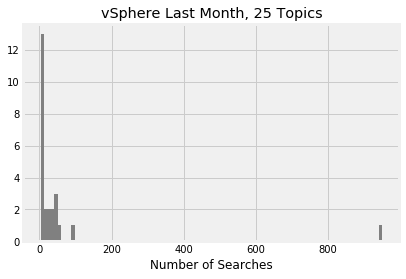

In [11]:
modeler = LDATopicModeler(vsphere_65, 25, key=lambda search: search.body)
modeler.run()

output_directory = '../output/lda-v2-centroid-top/vsphere-25-topics/'
try:
    os.makedirs(output_directory)
except:
    pass
export_topics(modeler, output_directory)
export_documents(modeler, output_directory)

show_count_histogram(modeler, "vSphere Last Month, 25 Topics")

## vSphere 6.5 Last Month 50 Topics

Starting training for 50 topics.
Vectors extracted in 0.093s.
Model fit in  21.529s.
Topic dataframe created in  40.475s.
Document dataframe created in  40.560s.
Top n-grams computed in  0.880s.
Failed for topic 16: list index out of range
Failed for topic 23: list index out of range
Failed for topic 47: list index out of range
Process completed in  103.618s.


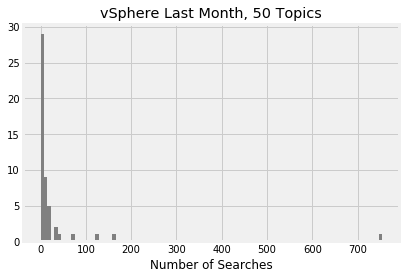

In [12]:
modeler = LDATopicModeler(vsphere_65, 50, key=lambda search: search.body)
modeler.run()

output_directory = '../output/lda-v2-centroid-top/vsphere-50-topics/'
try:
    os.makedirs(output_directory)
except:
    pass
export_topics(modeler, output_directory)
export_documents(modeler, output_directory)

show_count_histogram(modeler, "vSphere Last Month, 50 Topics")

## vSphere 6.5 Last Month 75 Topics

Starting training for 75 topics.
Vectors extracted in 0.096s.
Model fit in  31.600s.
Topic dataframe created in  61.654s.
Document dataframe created in  61.984s.
Top n-grams computed in  1.089s.
Failed for topic 3: list index out of range
Failed for topic 15: list index out of range
Failed for topic 24: list index out of range
Failed for topic 27: list index out of range
Failed for topic 35: list index out of range
Failed for topic 53: list index out of range
Failed for topic 54: list index out of range
Failed for topic 55: list index out of range
Failed for topic 57: list index out of range
Failed for topic 63: list index out of range
Failed for topic 65: list index out of range
Failed for topic 67: list index out of range
Failed for topic 71: list index out of range
Process completed in  156.538s.


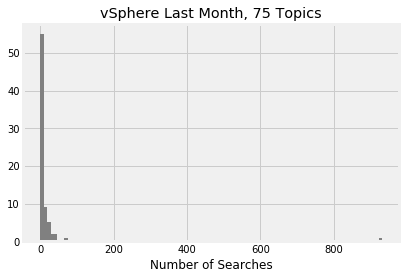

In [13]:
modeler = LDATopicModeler(vsphere_65, 75, key=lambda search: search.body)
modeler.run()

output_directory = '../output/lda-v2-centroid-top/vsphere-75-topics/'
try:
    os.makedirs(output_directory)
except:
    pass
export_topics(modeler, output_directory)
export_documents(modeler, output_directory)

show_count_histogram(modeler, "vSphere Last Month, 75 Topics")

## vSphere 6.5 Last Month 100 Topics

Starting training for 100 topics.
Vectors extracted in 0.092s.
Model fit in  43.480s.
Topic dataframe created in  81.905s.
Document dataframe created in  82.258s.
Top n-grams computed in  1.074s.
Failed for topic 2: list index out of range
Failed for topic 7: list index out of range
Failed for topic 8: list index out of range
Failed for topic 12: list index out of range
Failed for topic 13: list index out of range
Failed for topic 21: list index out of range
Failed for topic 25: list index out of range
Failed for topic 27: list index out of range
Failed for topic 30: list index out of range
Failed for topic 31: list index out of range
Failed for topic 37: list index out of range
Failed for topic 41: list index out of range
Failed for topic 42: list index out of range
Failed for topic 46: list index out of range
Failed for topic 49: list index out of range
Failed for topic 50: list index out of range
Failed for topic 52: list index out of range
Failed for topic 54: list index out of ran

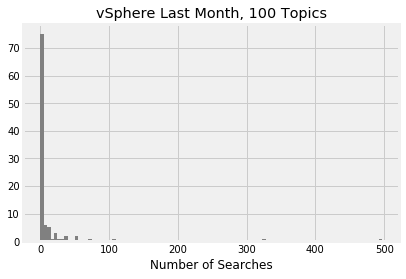

In [14]:
modeler = LDATopicModeler(vsphere_65, 100, key=lambda search: search.body)
modeler.run()

output_directory = '../output/lda-v2-centroid-top/vsphere-100-topics/'
try:
    os.makedirs(output_directory)
except:
    pass
export_topics(modeler, output_directory)
export_documents(modeler, output_directory)

show_count_histogram(modeler, "vSphere Last Month, 100 Topics")